In [38]:
import json
from nltk_utils import tokenize, stem, bag_of_words
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from model import NeuralNet
from sklearn.model_selection import train_test_split

In [39]:
def callback(epoch, num_epochs, loss, acc):
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}, Accuracy: {acc:.2f}%')


file_path = r'/home/user/idx/intents.json' #replace with your own path, yung path ng intents.json sa files mo, right click, copy as path
with open(file_path, 'r', encoding='utf-8') as f:
    intents = json.load(f)

In [40]:
all_words = []
tags = []
xy = []

# loop through each sentence in our intents patterns
for intent in intents['intents']:
    tag = intent['tag']
    tags.append(tag)
    for pattern in intent['patterns']:
        # tokenize each word in the sentence
        w = tokenize(pattern)
        # add to our words list
        all_words.extend(w)
        # add to xy pair
        xy.append((w, tag))

ignore_words = ['?', '!', '.', ',']

all_words = [stem(w) for w in all_words if w not in ignore_words]

all_words = sorted(set(all_words))

tags= sorted(set(tags))

In [41]:
X_train = []
y_train = []

for (pattern_sentence, tag) in xy:
    bag = bag_of_words(pattern_sentence, all_words)
    X_train.append(bag)

    label = tags.index(tag)
    y_train.append(label) # CrossEntropyLoss

X_train = np.array(X_train)
y_train = np.array(y_train, dtype=np.int64)

class ChatDataset(Dataset):
    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = X_train
        self.y_data = y_train
    
    # dataset[idx]
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.n_samples

In [42]:

# Hyper-parameters
batch_size = 8
hidden_size = 8
output_size = len(tags)
input_size = len(X_train[0])
learning_rate = 0.001
num_epochs = 1000


dataset = ChatDataset()
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNet(input_size, hidden_size, output_size).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [43]:

correct = 0
total = 0

for epoch in range(num_epochs):
    for (words, labels) in train_loader:
        words = words.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(words)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track the total and correct predictions
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    if (epoch+1) % 100 == 0:
        acc = 100 * correct / total
        callback(epoch, num_epochs, loss.item(), acc)

print(f'Final loss: {loss.item():.4f}, Final accuracy: {acc:.2f}%')

Epoch [100/1000], Loss: 0.3294, Accuracy: 59.41%
Epoch [200/1000], Loss: 0.0231, Accuracy: 79.71%
Epoch [300/1000], Loss: 0.0040, Accuracy: 86.47%
Epoch [400/1000], Loss: 0.0013, Accuracy: 89.85%
Epoch [500/1000], Loss: 0.0012, Accuracy: 91.88%
Epoch [600/1000], Loss: 0.0009, Accuracy: 93.24%
Epoch [700/1000], Loss: 0.0003, Accuracy: 94.20%
Epoch [800/1000], Loss: 0.0001, Accuracy: 94.93%
Epoch [900/1000], Loss: 0.0000, Accuracy: 95.49%
Epoch [1000/1000], Loss: 0.0000, Accuracy: 95.94%
Final loss: 0.0000, Final accuracy: 95.94%


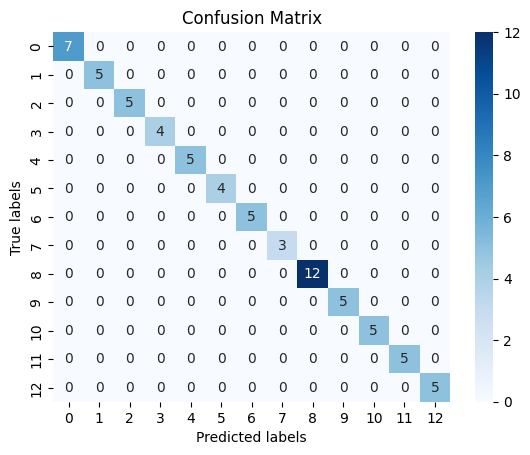

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70



In [44]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

test_dataset = ChatDataset()
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def calculate_confusion_matrix(model, data_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions, zero_division=1)  # Set zero_division to 1 to avoid warnings
    return cm, report

# Example usage:
confusion_matrix, classification_report = calculate_confusion_matrix(model, test_loader, device)

# Plot confusion matrix
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report)


In [45]:
data = {
    "model_state": model.state_dict(),
    "input_size": input_size,
    "output_size": output_size,
    "hidden_size": hidden_size,
    "all_words": all_words,
    "tags": tags
}

FILE = "data.pth"
torch.save(data, FILE)

print(f'Training complete. File saved to {FILE}')

Training complete. File saved to data.pth
